In [1]:
import os
import math
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import logging
import numpy as np
import torch


In [2]:
def calculate_entropy(file_path):


    with open(file_path, "rb") as file:
        data = file.read()
    
    counts = np.bincount(np.frombuffer(data, dtype=np.uint8), minlength=256)
    
    filesize = len(data)
    probabilities = counts / filesize

    probabilities = probabilities[probabilities > 0]

    entropy = -np.sum(probabilities * np.log2(probabilities))

    return entropy

def load_data(dataset_name):
    res = {}

    dataset_dir = os.path.join("..", "dataset", dataset_name)
    dataset_list = os.listdir(dataset_dir)

    for dataset in dataset_list:
        dataset_path = os.path.join( dataset_dir, dataset)
        filepath = os.listdir( dataset_path )
        
        res[dataset] = np.array( [os.path.join(dataset_path, f) for f in filepath] )

    res["name"] = dataset_name

    return res


def chooseDataset(i, dir_type, original_dataset, compared_dataset):
    if np.random.random() > 0.7: # mix 70/30 of the two datasets to ensure a good mix, goal is to predict encrypted files so majority of the dataset should be encrypted
        return original_dataset[dir_type][i] 
    else:
        return compared_dataset[dir_type][i]


def getFiles(original_dataset, compared_dataset):
    res = {}

    for key, value in compared_dataset.items():
        if key == 'name':
            res[key] = value
            continue
        res[key] = np.array( [f"{chooseDataset( i, key, original_dataset, compared_dataset ) }"  for i in range(len(value)) ])

    #print("Longueur txt : ", len(res['txt']), len(res['pdf']), len(res['png']), len(res['jpg']), len(res['csv']) )
    return res

def getFilesOneType(original_dataset, compared_dataset, type):
    res = {}
    res[type] = np.array( [f"{chooseDataset( i, type, original_dataset, compared_dataset ) }"  for i in range(len(compared_dataset[type])) ])
    return res

def computeFiles(d):
    cpy = {'txt': [], 'pdf': [], 'png': [], 'jpg': [], 'csv': []}
    for extensions in d:
        for i in range(len(d[extensions])):
            if extensions == 'name':
                continue

            filename = d[extensions][i]
            cpy[extensions].append([calculate_entropy(filename), filename, isEncrypted(filename)])
    return cpy
    

def isEncrypted(filepath):

    isEncrypted = -1
    
    if filepath.startswith('..\\dataset\\non_chiffre\\'):
        isEncrypted = 0
    
    elif filepath.endswith('.enc'):
        isEncrypted = 1
        
    extension = filepath

    entropy = calculate_entropy(filepath)
    infos = { 'isEncrypted': isEncrypted, 'extension': extension, 'entropy': entropy}
    return infos['isEncrypted']


In [3]:

dataset_dir = "../dataset/encrypted"
dataset_list = os.listdir(dataset_dir)
print(dataset_list)


original_dataset_name = "non_chiffre"
original_dataset = load_data(original_dataset_name)

pred_list = {}
toDisplay_list = {}

type_list = ['csv', 'jpg', 'pdf', 'png', 'txt']

experiments_results = {}

for foldertype in type_list:
    for compared_dataset_name in dataset_list:

        compared_dataset_name = dataset_dir + "/" + compared_dataset_name

        compared_choosen_dataset = load_data(compared_dataset_name)


        #fused_dataset = getFiles(original_dataset, compared_choosen_dataset)
        fused_dataset = getFilesOneType(original_dataset, compared_choosen_dataset, foldertype)
        fused_dataset = computeFiles(fused_dataset)

        print("Fused dataset : ", fused_dataset, " length : ", len(fused_dataset[foldertype]))
    


        x_data = np.array([fused_dataset[ext][i][0] for ext in fused_dataset for i in range(len(fused_dataset[ext]))])
        y_data = np.array([fused_dataset[ext][i][2] for ext in fused_dataset for i in range(len(fused_dataset[ext]))])


        print("X_data:", x_data.shape, "Y_data:", y_data.shape)
        
        x_train, x_test, y_train, res = train_test_split(x_data, y_data, test_size=0.3, random_state=0)

        print("x_train : ", x_train.shape, "y_train : ", y_train.shape, "x_test : ", x_test.shape, "y_test : ", res.shape)

        x_train = x_train.reshape(-1, 1)

        #fit the model
        model = svm.SVC(kernel='linear')
        model.fit(x_train, y_train)

        #test the trained model
        x_test = x_test.reshape(-1, 1)


        pred = model.predict(x_test)

        toDisplay = []

        for i in range(len(pred)):
            if (pred[i] == res[i]):
                toDisplay.append(1)
            else:
                toDisplay.append(0)

        print("Prediction : ", pred, (len(pred)))

        print("Original result", res, len(res))

        print("toDisplay : ", toDisplay, len(toDisplay))

        print( "Accuracy : ", model.score(x_train, y_train) )

        pred_list[compared_dataset_name] = pred
        modified = foldertype + '/' + compared_dataset_name
        toDisplay_list[modified] = toDisplay

        print("-----------------------------------")

    experiments_results[foldertype] = (pred_list, toDisplay_list)

print(experiments_results)



['aes-256-cbc', 'aes-256-ecb', 'bf-cbc', 'camellia-256-cbc', 'cast5-cbc', 'des-ede3-cbc', 'des-ede3-ecb', 'halfheaded', 'headless', 'randomized', 'rc4']
Fused dataset :  {'txt': [], 'pdf': [], 'png': [], 'jpg': [], 'csv': [[7.9999972519011, '..\\dataset\\../dataset/encrypted/aes-256-cbc\\csv\\0.csv.aes-256-cbc.enc', 1], [5.12817544243329, '..\\dataset\\non_chiffre\\csv\\1.csv', 0], [7.999997223518834, '..\\dataset\\../dataset/encrypted/aes-256-cbc\\csv\\10.csv.aes-256-cbc.enc', 1], [7.999997476258791, '..\\dataset\\../dataset/encrypted/aes-256-cbc\\csv\\11.csv.aes-256-cbc.enc', 1], [5.066806030736492, '..\\dataset\\non_chiffre\\csv\\12.csv', 0], [7.999997851166631, '..\\dataset\\../dataset/encrypted/aes-256-cbc\\csv\\13.csv.aes-256-cbc.enc', 1], [5.072638461784781, '..\\dataset\\non_chiffre\\csv\\14.csv', 0], [7.999997174660232, '..\\dataset\\../dataset/encrypted/aes-256-cbc\\csv\\15.csv.aes-256-cbc.enc', 1], [7.999997415569433, '..\\dataset\\../dataset/encrypted/aes-256-cbc\\csv\\16.c

In [4]:
csv_aes_256_cbc = experiments_results['csv'][1]['csv/../dataset/encrypted/aes-256-cbc']
csv_aes_256_ecb = experiments_results['csv'][1]['csv/../dataset/encrypted/aes-256-ecb']
csv_bf_cbc =      experiments_results['csv'][1]['csv/../dataset/encrypted/bf-cbc']
csv_camellia_256_cbc = experiments_results['csv'][1]['csv/../dataset/encrypted/camellia-256-cbc']
csv_cast5_cbc = experiments_results['csv'][1]['csv/../dataset/encrypted/cast5-cbc']
csv_des_ede3_cbc = experiments_results['csv'][1]['csv/../dataset/encrypted/des-ede3-cbc']
csv_des_ede3_ecb = experiments_results['csv'][1]['csv/../dataset/encrypted/des-ede3-ecb']
csv_rc4 = experiments_results['csv'][1]['csv/../dataset/encrypted/rc4']
csv_randomized = experiments_results['csv'][1]['csv/../dataset/encrypted/randomized']
csv_headless = experiments_results['csv'][1]['csv/../dataset/encrypted/headless']
csv_halfheaded = experiments_results['csv'][1]['csv/../dataset/encrypted/halfheaded']
csv_aes_128_cbc = experiments_results['csv'][1]['csv/../dataset/encrypted/aes-128-cbc']
csv_gpg = experiments_results['csv'][1]['csv/../dataset/encrypted/gpg']

jpg_aes_256_cbc = experiments_results['jpg'][1]['jpg/../dataset/encrypted/aes-256-cbc']
jpg_aes_256_ecb = experiments_results['jpg'][1]['jpg/../dataset/encrypted/aes-256-ecb']
jpg_bf_cbc =      experiments_results['jpg'][1]['jpg/../dataset/encrypted/bf-cbc']
jpg_camellia_256_cbc = experiments_results['jpg'][1]['jpg/../dataset/encrypted/camellia-256-cbc']
jpg_cast5_cbc = experiments_results['jpg'][1]['jpg/../dataset/encrypted/cast5-cbc']
jpg_des_ede3_cbc = experiments_results['jpg'][1]['jpg/../dataset/encrypted/des-ede3-cbc']
jpg_des_ede3_ecb = experiments_results['jpg'][1]['jpg/../dataset/encrypted/des-ede3-ecb']
jpg_rc4 = experiments_results['jpg'][1]['jpg/../dataset/encrypted/rc4']
jpg_randomized = experiments_results['jpg'][1]['jpg/../dataset/encrypted/randomized']
jpg_headless = experiments_results['jpg'][1]['jpg/../dataset/encrypted/headless']
jpg_halfheaded = experiments_results['jpg'][1]['jpg/../dataset/encrypted/halfheaded']
jpg_aes_128_cbc = experiments_results['jpg'][1]['jpg/../dataset/encrypted/aes-128-cbc']
jpg_gpg = experiments_results['jpg'][1]['jpg/../dataset/encrypted/gpg']

pdf_aes_256_cbc = experiments_results['pdf'][1]['pdf/../dataset/encrypted/aes-256-cbc']
pdf_aes_256_ecb = experiments_results['pdf'][1]['pdf/../dataset/encrypted/aes-256-ecb']
pdf_bf_cbc =      experiments_results['pdf'][1]['pdf/../dataset/encrypted/bf-cbc']
pdf_camellia_256_cbc = experiments_results['pdf'][1]['pdf/../dataset/encrypted/camellia-256-cbc']
pdf_cast5_cbc = experiments_results['pdf'][1]['pdf/../dataset/encrypted/cast5-cbc']
pdf_des_ede3_cbc = experiments_results['pdf'][1]['pdf/../dataset/encrypted/des-ede3-cbc']
pdf_des_ede3_ecb = experiments_results['pdf'][1]['pdf/../dataset/encrypted/des-ede3-ecb']
pdf_rc4 = experiments_results['pdf'][1]['pdf/../dataset/encrypted/rc4']
pdf_randomized = experiments_results['pdf'][1]['pdf/../dataset/encrypted/randomized']
pdf_headless = experiments_results['pdf'][1]['pdf/../dataset/encrypted/headless']
pdf_halfheaded = experiments_results['pdf'][1]['pdf/../dataset/encrypted/halfheaded'] 
pdf_aes_128_cbc = experiments_results['pdf'][1]['pdf/../dataset/encrypted/aes-128-cbc']
pdf_gpg = experiments_results['pdf'][1]['pdf/../dataset/encrypted/gpg']

png_aes_256_cbc = experiments_results['png'][1]['png/../dataset/encrypted/aes-256-cbc']
png_aes_256_ecb = experiments_results['png'][1]['png/../dataset/encrypted/aes-256-ecb']
png_bf_cbc =      experiments_results['png'][1]['png/../dataset/encrypted/bf-cbc']
png_camellia_256_cbc = experiments_results['png'][1]['png/../dataset/encrypted/camellia-256-cbc']
png_cast5_cbc = experiments_results['png'][1]['png/../dataset/encrypted/cast5-cbc']
png_des_ede3_cbc = experiments_results['png'][1]['png/../dataset/encrypted/des-ede3-cbc']
png_des_ede3_ecb = experiments_results['png'][1]['png/../dataset/encrypted/des-ede3-ecb']
png_rc4 = experiments_results['png'][1]['png/../dataset/encrypted/rc4']
png_randomized = experiments_results['png'][1]['png/../dataset/encrypted/randomized']
png_headless = experiments_results['png'][1]['png/../dataset/encrypted/headless']
png_halfheaded = experiments_results['png'][1]['png/../dataset/encrypted/halfheaded']
png_aes_128_cbc = experiments_results['png'][1]['png/../dataset/encrypted/aes-128-cbc']
png_gpg = experiments_results['png'][1]['png/../dataset/encrypted/gpg']

txt_aes_256_cbc = experiments_results['txt'][1]['txt/../dataset/encrypted/aes-256-cbc']
txt_aes_256_ecb = experiments_results['txt'][1]['txt/../dataset/encrypted/aes-256-ecb']
txt_bf_cbc =      experiments_results['txt'][1]['txt/../dataset/encrypted/bf-cbc']
txt_camellia_256_cbc = experiments_results['txt'][1]['txt/../dataset/encrypted/camellia-256-cbc']
txt_cast5_cbc = experiments_results['txt'][1]['txt/../dataset/encrypted/cast5-cbc']
txt_des_ede3_cbc = experiments_results['txt'][1]['txt/../dataset/encrypted/des-ede3-cbc']
txt_des_ede3_ecb = experiments_results['txt'][1]['txt/../dataset/encrypted/des-ede3-ecb']
txt_rc4 = experiments_results['txt'][1]['txt/../dataset/encrypted/rc4']
txt_randomized = experiments_results['txt'][1]['txt/../dataset/encrypted/randomized']
txt_headless = experiments_results['txt'][1]['txt/../dataset/encrypted/headless']
txt_halfheaded = experiments_results['txt'][1]['txt/../dataset/encrypted/halfheaded']
txt_aes_128_cbc = experiments_results['txt'][1]['txt/../dataset/encrypted/aes-128-cbc']
txt_gpg = experiments_results['txt'][1]['txt/../dataset/encrypted/gpg']

aes_128_cbc = [csv_aes_128_cbc, jpg_aes_128_cbc, pdf_aes_128_cbc, png_aes_128_cbc, txt_aes_128_cbc]
aes_256_cbc = [csv_aes_256_cbc, jpg_aes_256_cbc, pdf_aes_256_cbc, png_aes_256_cbc, txt_aes_256_cbc]
aes_256_ecb = [csv_aes_256_ecb, jpg_aes_256_ecb, pdf_aes_256_ecb, png_aes_256_ecb, txt_aes_256_ecb]
bf_cbc = [csv_bf_cbc, jpg_bf_cbc, pdf_bf_cbc, png_bf_cbc, txt_bf_cbc]
camellia_256_cbc = [csv_camellia_256_cbc, jpg_camellia_256_cbc, pdf_camellia_256_cbc, png_camellia_256_cbc, txt_camellia_256_cbc]
cast5_cbc = [csv_cast5_cbc, jpg_cast5_cbc, pdf_cast5_cbc, png_cast5_cbc, txt_cast5_cbc]
des_ede3_cbc = [csv_des_ede3_cbc, jpg_des_ede3_cbc, pdf_des_ede3_cbc, png_des_ede3_cbc, txt_des_ede3_cbc]
des_ede3_ecb = [csv_des_ede3_ecb, jpg_des_ede3_ecb, pdf_des_ede3_ecb, png_des_ede3_ecb, txt_des_ede3_ecb]
rc4 = [csv_rc4, jpg_rc4, pdf_rc4, png_rc4, txt_rc4]
randomized = [csv_randomized, jpg_randomized, pdf_randomized, png_randomized, txt_randomized]
headless = [csv_headless, jpg_headless, pdf_headless, png_headless, txt_headless]
halfheaded = [csv_halfheaded, jpg_halfheaded, pdf_halfheaded, png_halfheaded, txt_halfheaded]
gpg = [csv_gpg, jpg_gpg, pdf_gpg, png_gpg, txt_gpg]

In [5]:
print("test : ", csv_aes_256_cbc  )
print("test : ", csv_aes_256_ecb  )
print("test : ", csv_bf_cbc )
print("test : ", csv_camellia_256_cbc  )
print("test : ", csv_cast5_cbc  )
print("test : ", csv_des_ede3_cbc  )
print("test : ", csv_des_ede3_ecb  )
print("test : ", csv_rc4 )
print("test : ", csv_randomized  )
print("test : ", csv_headless  )
print("test : ", csv_halfheaded  )
print("test : ", csv_aes_128_cbc  )
print("test : ", csv_gpg

print("test : ", jpg_aes_256_cbc  )
print("test : ", jpg_aes_256_ecb  )
print("test : ", jpg_bf_cbc )
print("test : ", jpg_camellia_256_cbc  )
print("test : ", jpg_cast5_cbc )
print("test : ", jpg_des_ede3_cbc   )
print("test : ", jpg_des_ede3_ecb   )
print("test : ", jpg_rc4   )
print("test : ", jpg_randomized  )
print("test : ", jpg_headless  )
print("test : ", jpg_halfheaded  )
print("test : ", jpg_aes_128_cbc  )
print("test : ", jpg_gpg  )


print("test : ", pdf_aes_256_cbc  )
print("test : ", pdf_aes_256_ecb )
print("test : ", pdf_bf_cbc )
print("test : ", pdf_camellia_256_cbc  )
print("test : ", pdf_cast5_cbc )
print("test : ", pdf_des_ede3_cbc   )
print("test : ", pdf_des_ede3_ecb   )
print("test : ", pdf_rc4   )
print("test : ", pdf_randomized  )
print("test : ", pdf_headless  )
print("test : ", pdf_halfheaded  )
print("test : ", pdf_aes_128_cbc  )
print("test : ", pdf_gpg  )


print("test : ", png_aes_256_cbc  )
print("test : ", png_aes_256_ecb  )
print("test : ", png_bf_cbc )
print("test : ", png_camellia_256_cbc )
print("test : ", png_cast5_cbc )
print("test : ", png_des_ede3_cbc   )
print("test : ", png_des_ede3_ecb   )
print("test : ", png_rc4   )
print("test : ", png_randomized  )
print("test : ", png_headless  )
print("test : ", png_halfheaded  )
print("test : ", png_aes_128_cbc  )
print("test : ", png_gpg  )


print("test : ", txt_aes_256_cbc)
print("test : ", txt_aes_256_ecb  )
print("test : ", txt_bf_cbc )
print("test : ", txt_camellia_256_cbc  )
print("test : ", txt_cast5_cbc )
print("test : ", txt_des_ede3_cbc   )
print("test : ", txt_des_ede3_ecb   )
print("test : ", txt_rc4   )
print("test : ", txt_randomized  )
print("test : ", txt_headless  )
print("test : ", txt_halfheaded  )
print("test : ", txt_aes_128_cbc  )
print("test : ", txt_gpg  )


test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 1, 1, 1, 1]
test :  [1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0]
test :  [1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0]
test :  [0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
test :  [0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1]
test :  [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0]
test :  [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
test :  [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1]
test :  [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]
test :  [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1]
test :  [1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
test :  [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
test :  [1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
test :  [0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]
test :  [1, 1, 0, 1

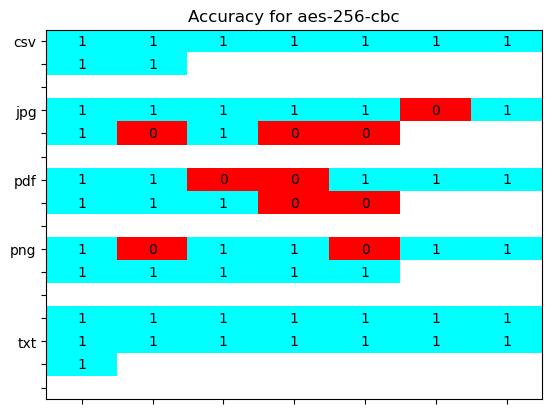

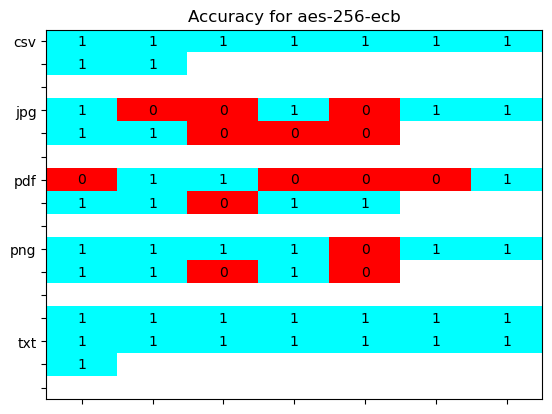

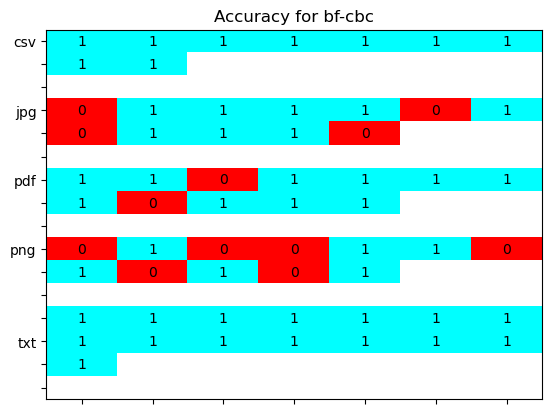

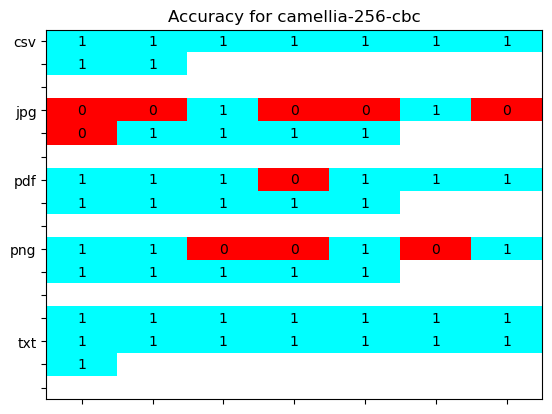

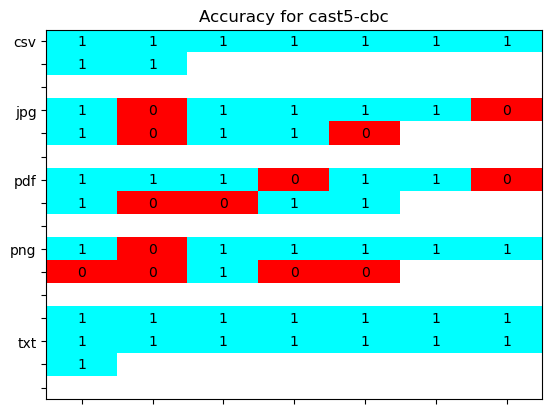

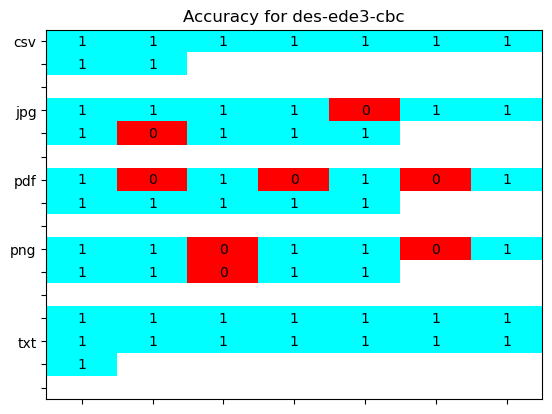

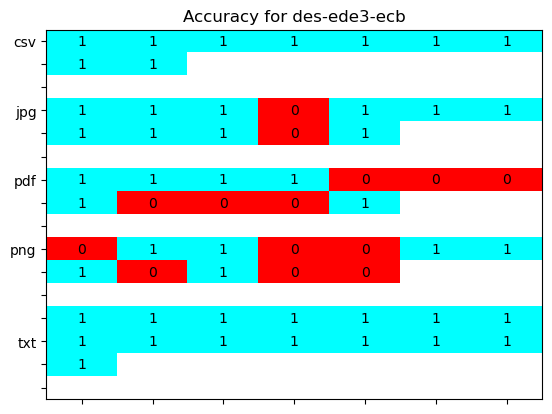

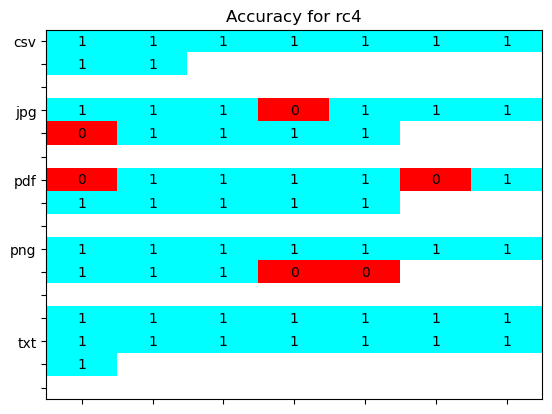

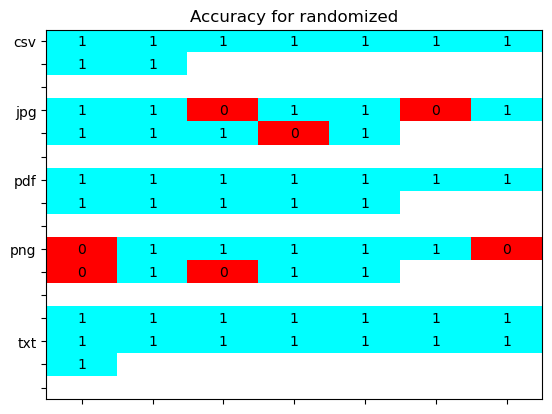

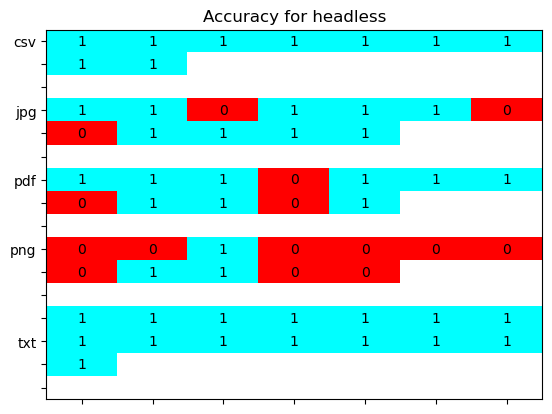

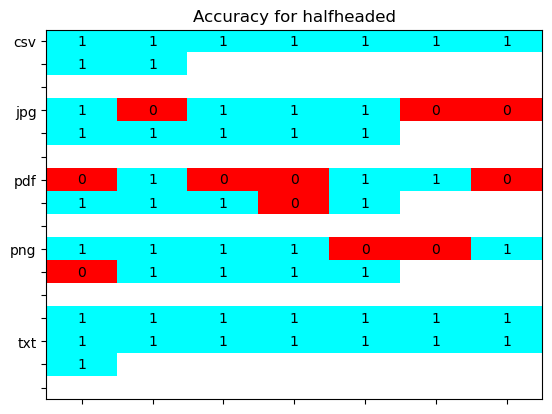

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap




def split_list_by_seven(input_array):
    split_arrays = []
    
    # Iterate over the input array with a step size of 7
    for i in range(0, len(input_array), 7):
        # Extract subarray of seven items
        subarray = input_array[i:i+7]
        
        # Check if the subarray has less than seven items
        if len(subarray) < 7:
            # Fill the remaining positions with np.nan
            fill_array = np.full((7 - len(subarray),), np.nan)
            subarray = np.concatenate((subarray, fill_array))
        
        # Append the subarray to the split_arrays
        split_arrays.append(subarray)
    
    return np.array(split_arrays)


def printData(data):
    for i in range(len(data)):
        print(data[i], "\n")


def stack(list1, list2):
    return np.concatenate((list1, list2), axis=0)

def getLabels(n):
    x = int( (int(n) - 5) / 5)
    return  ["csv"] + [" "] * x + ["jpg"] + [" "] * x + ["pdf"]  + [" "] * x + ["png"] + [""] * (x+1) + ["txt"] + [""] * x

datasets_results_experiments = [aes_128_cbc,aes_256_cbc, aes_256_ecb, bf_cbc, camellia_256_cbc, cast5_cbc, des_ede3_cbc, des_ede3_ecb, rc4, randomized, headless, halfheaded, gpg]
datasets_results_experiments_names = ['aes-128-cbc','aes-256-cbc', 'aes-256-ecb', 'bf-cbc', 'camellia-256-cbc', 'cast5-cbc', 'des-ede3-cbc', 'des-ede3-ecb', 'rc4', 'randomized', 'headless', 'halfheaded', 'gpg']


typeR_names = ['csv', 'jpg', 'pdf', 'png', 'txt']

for algoR in range(len(datasets_results_experiments)):
    final_data = np.array([])

    dste = datasets_results_experiments[algoR]

    final_data =  split_list_by_seven(dste[0])
    final_data = np.vstack( (final_data, np.array([np.nan] * 7)))

    final_data = stack( final_data,  split_list_by_seven(dste[1]) )
    final_data = np.vstack( (final_data, np.array([np.nan] * 7)))

    final_data = stack(final_data,  split_list_by_seven(dste[2]) )
    final_data = np.vstack( (final_data, np.array([np.nan] * 7)))

    final_data = stack(final_data,  split_list_by_seven(dste[3]))
    final_data = np.vstack( (final_data, np.array([np.nan] * 7)))

    final_data = stack(final_data,  split_list_by_seven(dste[4]))
    final_data = np.vstack( (final_data, np.array([np.nan] * 7)))

    colors = ['red', 'cyan']

    # Create the colormap
    cmap = LinearSegmentedColormap.from_list('percent_gradient', colors)
    cmap.set_bad(color='white')
    plt.imshow(final_data, cmap=cmap, vmin=0, vmax=1, aspect='auto', interpolation='none')

    #plt.colorbar(label='Accuracy', orientation='horizontal' ) 
    plt.title('Accuracy for ' + datasets_results_experiments_names[algoR] )


    y_labels = ["csv"] * 2 + [" "] + ["jpg"] *2 + [" "] +  ["png"] * 2 + [" "] +  ["pdf"] * 2 + [" "] + ["txt"] * 2 + [" "]
    x_labels = ['' for i in range(7)]

    plt.xticks(ticks=np.arange(final_data.shape[1]), labels=x_labels)
    plt.yticks(ticks=np.arange(final_data.shape[0]), labels=getLabels(final_data.shape[0]))

    for i in range(final_data.shape[0]):
        for j in range(final_data.shape[1]):
            value = final_data[i, j]
            if not np.isnan(value):
                plt.text(j, i, int(value), ha='center', va='center', color='black')
    
    plt.savefig("results/" + f"svm_{datasets_results_experiments_names[algoR]}.png", bbox_inches='tight')  # Save with high resolution and tight bounding box)

    plt.show()


